## Description

I wants understand why my train is different on other people where i wrong?
I train default how i train another model detection and convolution but i see in kernels in kaggle people use another techicks to train nlp model and i can't understand why and i want test it.

Links to use:
- [22nd solution](https://www.kaggle.com/c/commonlitreadabilityprize/discussion/257302)

- [gtihub link](https://github.com/kurupical/commonlit)

- [RoBERTa Base Fine-Tuning with Better Training Strategies](https://www.kaggle.com/rhtsingh/commonlit-readability-prize-roberta-torch-fit)

## default or not changed loads

In [ ]:
from IPython.display import clear_output
!pip install transformers
clear_output()

In [ ]:
import re
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import  DataLoader, Dataset
import transformers

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


path_tr = '/content/drive/MyDrive/CommonLit/input/train.csv'
path_test = '/content/drive/MyDrive/CommonLit/input/test.csv'
path_sub = '/content/drive/MyDrive/CommonLit/input/sample_submission.csv'


SEED =13
np.random.seed(SEED)
torch.manual_seed(SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def make_folds(data: pd.DataFrame, split: int = 5):
    data['kfold'] = -1
    data = data.sample(frac =1).reset_index(drop=True)
    num_bins = int(np.floor(1 + np.log2(len(data))))
    data.loc[:, 'bins'] = pd.cut(
        data['target'], bins = num_bins, labels = False
    )
    kf = model_selection.StratifiedKFold(n_splits=split)
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
    data = data.drop("bins", axis=1)
    return data


def clean_text(txt):
    return re.sub('[^A-Za-z]+', ' ',str(txt).lower())


df = pd.read_csv(path_tr)
df['txt'] = df['excerpt']#.apply(lambda x: clean_text(x))
df_folds = make_folds(df, 5)

In [ ]:
class CL_Dataset(Dataset):

    def __init__(
        self,
        data: pd.DataFrame,
        token,
        max_len: int = 256,
        test: bool = False
        ) -> dict:
        self.data = data 
        self.max_len = max_len
        self.test = test
        self.token = token

    def __len__(self):
        return self.data.shape[0]

    def  __getitem__(self, idx: int):
        text = self.data.txt.iloc[idx]
        encode = self.token(
            text,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            add_special_tokens=True,            
            return_attention_mask=True,
            return_token_type_ids=False  
            )
        if self.test:
            target = 0
        else:
            target = self.data.target.iloc[idx]

        ids = encode["input_ids"]
        mask = encode["attention_mask"]

        return {
            "input_ids": torch.tensor(ids, dtype=torch.long),
            "attention_mask": torch.tensor(mask, dtype=torch.long),
            'target': torch.tensor(target, dtype = torch.float)  
        }

In [ ]:
def loss_fn(output,target):
    return torch.sqrt(nn.MSELoss()(output,target))


def viz_curve(data: dict, title: str) -> None:
    epochs = list(range(1, EPOCH + 1))
    fig = make_subplots(
        rows=2, cols=2,
        specs=[
               [{"colspan": 2}, None],
               [{}, {}],
               ],
               vertical_spacing=0.09,
               subplot_titles=('Loss Curve',  'RMSE', 'LR')
    )
    fig.add_trace(
        go.Scatter(
            x=epochs,
            y=data['train_loss'],
            mode='lines+markers',
            name='Train Loss'),
            row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=epochs,
            y=data['valid_loss'],
            mode='lines+markers',
            name='Valid Loss'),
            row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=epochs,
            y=data['valid_rms'],
            mode='lines+markers',
            name='RMSE'),     
            row=2, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=epochs,
            y=data['lr'],
            mode='lines+markers',
            name='LR'), 
            row=2, col=2
    )
    fig.update_layout(
        height=600,
        width=600,
        showlegend=False,
        title = title,
        margin=dict(l=10, r=10, t=30, b=20),                     
        template="plotly_dark"    
    )
    fig.show()

def update_result(
    data: dict,
    predict: torch.tensor,
    target:torch.tensor
) -> None:
    loss = loss_fn(predict.squeeze(-1), target)
    data['losses'].append(loss.detach().cpu().numpy())
    data['all_pred'].append(predict.squeeze(-1).detach().cpu().numpy())
    data['all_target'].append(target.detach().cpu().numpy())
    return loss


def train(
    model:nn.Module, 
    loader: DataLoader,
    optimizer: transformers.AdamW,
    schedule: transformers.get_linear_schedule_with_warmup,
    batch: int,
    max_lenght: int
) -> list:
    model.train()
    torch.backends.cudnn.benchmark = True
    results = defaultdict(list)
    for input in loader:
        optimizer.zero_grad()
        target = input['target'].to(device)
        batch = {k:v.to(device) for k,v in input.items() if k != 'target'}   
        out = model(**batch)
        out = out.logits # BertForSequenceClassification
        loss = update_result(results, out, target)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()    
        schedule.step()
    losses = np.mean(results['losses'])
    allt = np.concatenate(results['all_target'])
    allp = np.concatenate(results['all_pred'])
    rmse = np.sqrt(mean_squared_error(allt, allp))  
    return losses, rmse


def validate(
    model:nn.Module, 
    loader: DataLoader, 
    batch: int,
    max_lenght: int
) -> list:
    model.eval()
    results = defaultdict(list)
    for input in loader:  
        target = input['target'].to(device)
        batch = {k:v.to(device) for k,v in input.items() if k != 'target'} 
        out = model(**batch)
        out = out.logits # BertForSequenceClassification
        _ = update_result(results, out, target)
    losses = np.mean(results['losses'])
    allt = np.concatenate(results['all_target'])
    allp = np.concatenate(results['all_pred'])
    rmse = np.sqrt(mean_squared_error(allt, allp)) 
    return losses, rmse


def showtime(model:nn.Module, data: pd.DataFrame, tokenizer:transformers.AutoTokenizer, fold: int) -> dict:    
    history = defaultdict(list)
    model = model.to(device)
    ttr = data[data.kfold != fold].reset_index(drop=True)
    vvl = data[data.kfold == fold].reset_index(drop=True)
    print(f'Fold: {fold + 1}, --- {ttr.shape, vvl.shape}')

    tr = CL_Dataset(ttr,tokenizer, MAX_LEN)
    vl = CL_Dataset(vvl,tokenizer, MAX_LEN)
    tr_loader = DataLoader(
        tr,
        batch_size=BATCH,
        shuffle=True
    )
    vl_loader = DataLoader(
        vl,
        batch_size=BATCH,
        shuffle=False
    )
    optimizer = transformers.AdamW(model.parameters(), lr=2e-5, correct_bias=True)
    steps = len(tr_loader) * EPOCH
    print(steps, len(tr_loader))
    # steps = len(tr_loader)/BATCH * EPOCH
    lin_schedule = transformers.get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=1,
        num_training_steps=steps
    )
    best_rmse = np.inf
    for epoch in tqdm(range(EPOCH)):
        tr_loss, tr_rmse = train(model, tr_loader, optimizer, lin_schedule, BATCH, MAX_LEN)
        vl_loss, vl_rmse = validate(model, vl_loader, BATCH, MAX_LEN)
        lr = optimizer.param_groups[0]['lr']
        history['train_loss'].append(tr_loss)
        history['valid_loss'].append(vl_loss)
        history['valid_rms'].append(vl_rmse)
        history['lr'].append(lr)
        print(f'Epoch: {epoch}, lr: {lr}, train rmse: {tr_rmse}, vl rmse: {vl_rmse}, vl loss: {vl_loss}')
        if vl_rmse < best_rmse:
            print(f'Save rmse: {vl_rmse}')
            torch.save(model.state_dict(), f'{MODEL}_model_{fold}.pth')
            best_rmse = vl_rmse
    return history

In [ ]:
class Auto_NLP_model:
    def __init__(self, name: str, n_labels: int = 1):
        print(f'Auto NLP init model : {name}')
        self.name = name
        self.n_labels=  n_labels        
    
    def loads(self):
        print('Loading configuraiton...')
        model_config = transformers.AutoConfig.from_pretrained(
                pretrained_model_name_or_path=self.name,
                num_labels=self.n_labels)
        print('Loading tokenizer...')
        tokenizer = transformers.AutoTokenizer.from_pretrained(
                pretrained_model_name_or_path=self.name)
        print('Loading model...')
        model = transformers.AutoModelForSequenceClassification.from_pretrained(
                pretrained_model_name_or_path=self.name,
                config=model_config)
        return model, tokenizer

In [ ]:
"""
https://huggingface.co/transformers/pretrained_models.html
https://huggingface.co/transformers/model_doc/auto.html

"""

m = {
    # 'xlm-roberta':'xlm-roberta-base',
    # 'deberta': 'microsoft/deberta-base',
    # 'xlm':'xlm-mlm-ende-1024',
    # 'camembert': 'camembert-base',
    # 'mbart': 'facebook/mbart-large-cc25', #memory batch 4 not ends error
    'roberta': 'roberta-base' #roberta-large'
}

In [ ]:
EPOCH = 15
BATCH = 6
MAX_LEN = 256

for k, v in m.items():
    print(k)
    model, tokenizer = Auto_NLP_model(v).loads()
    MODEL = model.__class__.__name__
    fold = 0
    title = f'Model: {k} Fold: {fold + 1}'
    history = showtime(model, df_folds, tokenizer, fold)
    viz_curve(history, title)

roberta
Auto NLP init model : roberta-base
Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Fold: 1, --- ((2267, 8), (567, 8))
5670 378


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0, lr: 1.866995942847063e-05, train rmse: 0.7436621189117432, vl rmse: 0.6540188789367676, vl loss: 0.6269398927688599
Save rmse: 0.6540188789367676


  7%|▋         | 1/15 [04:03<56:50, 243.59s/it]

Epoch: 1, lr: 1.7336390897865588e-05, train rmse: 0.5260870456695557, vl rmse: 0.6349746584892273, vl loss: 0.6099616289138794
Save rmse: 0.6349746584892273


 20%|██        | 3/15 [12:09<48:35, 242.93s/it]

Epoch: 2, lr: 1.6002822367260542e-05, train rmse: 0.4299793243408203, vl rmse: 0.6682462096214294, vl loss: 0.6423256397247314
Epoch: 3, lr: 1.4669253836655498e-05, train rmse: 0.36037909984588623, vl rmse: 0.543418824672699, vl loss: 0.5201668739318848
Save rmse: 0.543418824672699


 33%|███▎      | 5/15 [20:15<40:29, 242.91s/it]

Epoch: 4, lr: 1.333568530605045e-05, train rmse: 0.3064141869544983, vl rmse: 0.5811491012573242, vl loss: 0.5575568079948425


 40%|████      | 6/15 [24:17<36:24, 242.74s/it]

Epoch: 5, lr: 1.2002116775445406e-05, train rmse: 0.2750021517276764, vl rmse: 0.582738995552063, vl loss: 0.5591065883636475
Epoch: 6, lr: 1.066854824484036e-05, train rmse: 0.241420716047287, vl rmse: 0.5221829414367676, vl loss: 0.4948228895664215
Save rmse: 0.5221829414367676


 53%|█████▎    | 8/15 [32:23<28:20, 242.88s/it]

Epoch: 7, lr: 9.334979714235315e-06, train rmse: 0.22280079126358032, vl rmse: 0.5436638593673706, vl loss: 0.5197162628173828


 60%|██████    | 9/15 [36:26<24:16, 242.72s/it]

Epoch: 8, lr: 8.001411183630271e-06, train rmse: 0.1977776437997818, vl rmse: 0.5721029043197632, vl loss: 0.5503267645835876


 67%|██████▋   | 10/15 [40:30<20:16, 243.21s/it]

Epoch: 9, lr: 6.667842653025225e-06, train rmse: 0.18672426044940948, vl rmse: 0.5271970629692078, vl loss: 0.5030388236045837


 73%|███████▎  | 11/15 [44:35<16:14, 243.60s/it]

Epoch: 10, lr: 5.33427412242018e-06, train rmse: 0.16900299489498138, vl rmse: 0.5574540495872498, vl loss: 0.5334554314613342


 80%|████████  | 12/15 [48:39<12:11, 243.90s/it]

Epoch: 11, lr: 4.0007055918151355e-06, train rmse: 0.15365661680698395, vl rmse: 0.5263659954071045, vl loss: 0.5023990273475647


 87%|████████▋ | 13/15 [52:44<08:08, 244.14s/it]

Epoch: 12, lr: 2.66713706121009e-06, train rmse: 0.14275813102722168, vl rmse: 0.585809588432312, vl loss: 0.562573254108429


 93%|█████████▎| 14/15 [56:48<04:04, 244.24s/it]

Epoch: 13, lr: 1.333568530605045e-06, train rmse: 0.13657480478286743, vl rmse: 0.5636139512062073, vl loss: 0.5399689674377441


100%|██████████| 15/15 [1:00:53<00:00, 243.57s/it]

Epoch: 14, lr: 0.0, train rmse: 0.12706246972084045, vl rmse: 0.5606884360313416, vl loss: 0.5367791652679443


### results:

results model roberta-large(~1h:45min):

```
# This is formatted as code
Fold: 1, --- ((2267, 8), (567, 8))
  0%|          | 0/15 [00:00<?, ?it/s]Epoch: 0, lr: 1.866995942847063e-05, train rmse: 0.771242618560791, vl rmse: 0.5320066809654236, vl loss: 0.5065193772315979
Save rmse: 0.5320066809654236
 13%|█▎        | 2/15 [13:49<1:30:08, 416.03s/it]Epoch: 1, lr: 1.7336390897865588e-05, train rmse: 0.5480484366416931, vl rmse: 0.7261704802513123, vl loss: 0.7056165933609009
 20%|██        | 3/15 [20:51<1:23:43, 418.63s/it]Epoch: 2, lr: 1.6002822367260542e-05, train rmse: 0.45481783151626587, vl rmse: 0.5933656096458435, vl loss: 0.5674742460250854
 27%|██▋       | 4/15 [27:52<1:16:56, 419.67s/it]Epoch: 3, lr: 1.4669253836655498e-05, train rmse: 0.3679790794849396, vl rmse: 0.6310817003250122, vl loss: 0.6084640622138977
 33%|███▎      | 5/15 [34:54<1:10:04, 420.41s/it]Epoch: 4, lr: 1.333568530605045e-05, train rmse: 0.3390931189060211, vl rmse: 0.7398288249969482, vl loss: 0.721051037311554
 40%|████      | 6/15 [41:56<1:03:08, 420.91s/it]Epoch: 5, lr: 1.2002116775445406e-05, train rmse: 0.2956746220588684, vl rmse: 0.5392723083496094, vl loss: 0.5154401659965515
 47%|████▋     | 7/15 [48:58<56:11, 421.40s/it]  Epoch: 6, lr: 1.066854824484036e-05, train rmse: 0.2643064260482788, vl rmse: 0.5453745126724243, vl loss: 0.5227868556976318
 53%|█████▎    | 8/15 [56:01<49:11, 421.65s/it]Epoch: 7, lr: 9.334979714235315e-06, train rmse: 0.25952309370040894, vl rmse: 0.6315166354179382, vl loss: 0.6088392734527588
 60%|██████    | 9/15 [1:03:03<42:11, 421.85s/it]Epoch: 8, lr: 8.001411183630271e-06, train rmse: 0.2210676074028015, vl rmse: 0.659906804561615, vl loss: 0.6411230564117432
 67%|██████▋   | 10/15 [1:10:05<35:10, 422.07s/it]Epoch: 9, lr: 6.667842653025225e-06, train rmse: 0.21520286798477173, vl rmse: 0.5818750262260437, vl loss: 0.5584777593612671
Epoch: 10, lr: 5.33427412242018e-06, train rmse: 0.20328344404697418, vl rmse: 0.5239043235778809, vl loss: 0.4989898204803467
Save rmse: 0.5239043235778809
 80%|████████  | 12/15 [1:24:15<21:09, 423.21s/it]Epoch: 11, lr: 4.0007055918151355e-06, train rmse: 0.18055203557014465, vl rmse: 0.5367754697799683, vl loss: 0.5130714178085327
 87%|████████▋ | 13/15 [1:31:17<14:05, 422.95s/it]Epoch: 12, lr: 2.66713706121009e-06, train rmse: 0.1665629744529724, vl rmse: 0.5970629453659058, vl loss: 0.5752689838409424
 93%|█████████▎| 14/15 [1:38:19<07:02, 422.65s/it]Epoch: 13, lr: 1.333568530605045e-06, train rmse: 0.15745727717876434, vl rmse: 0.5785849094390869, vl loss: 0.5563144683837891
100%|██████████| 15/15 [1:45:21<00:00, 421.43s/it]Epoch: 14, lr: 0.0, train rmse: 0.14649353921413422, vl rmse: 0.5729362964630127, vl loss: 0.5512558817863464

make small version robrta base 1h:

Fold: 1, --- ((2267, 8), (567, 8))
5670 378
  0%|          | 0/15 [00:00<?, ?it/s]Epoch: 0, lr: 1.866995942847063e-05, train rmse: 0.7436621189117432, vl rmse: 0.6540188789367676, vl loss: 0.6269398927688599
Save rmse: 0.6540188789367676
  7%|▋         | 1/15 [04:03<56:50, 243.59s/it]Epoch: 1, lr: 1.7336390897865588e-05, train rmse: 0.5260870456695557, vl rmse: 0.6349746584892273, vl loss: 0.6099616289138794
Save rmse: 0.6349746584892273
 20%|██        | 3/15 [12:09<48:35, 242.93s/it]Epoch: 2, lr: 1.6002822367260542e-05, train rmse: 0.4299793243408203, vl rmse: 0.6682462096214294, vl loss: 0.6423256397247314
Epoch: 3, lr: 1.4669253836655498e-05, train rmse: 0.36037909984588623, vl rmse: 0.543418824672699, vl loss: 0.5201668739318848
Save rmse: 0.543418824672699
 33%|███▎      | 5/15 [20:15<40:29, 242.91s/it]Epoch: 4, lr: 1.333568530605045e-05, train rmse: 0.3064141869544983, vl rmse: 0.5811491012573242, vl loss: 0.5575568079948425
 40%|████      | 6/15 [24:17<36:24, 242.74s/it]Epoch: 5, lr: 1.2002116775445406e-05, train rmse: 0.2750021517276764, vl rmse: 0.582738995552063, vl loss: 0.5591065883636475
Epoch: 6, lr: 1.066854824484036e-05, train rmse: 0.241420716047287, vl rmse: 0.5221829414367676, vl loss: 0.4948228895664215
Save rmse: 0.5221829414367676
 53%|█████▎    | 8/15 [32:23<28:20, 242.88s/it]Epoch: 7, lr: 9.334979714235315e-06, train rmse: 0.22280079126358032, vl rmse: 0.5436638593673706, vl loss: 0.5197162628173828
 60%|██████    | 9/15 [36:26<24:16, 242.72s/it]Epoch: 8, lr: 8.001411183630271e-06, train rmse: 0.1977776437997818, vl rmse: 0.5721029043197632, vl loss: 0.5503267645835876
 67%|██████▋   | 10/15 [40:30<20:16, 243.21s/it]Epoch: 9, lr: 6.667842653025225e-06, train rmse: 0.18672426044940948, vl rmse: 0.5271970629692078, vl loss: 0.5030388236045837
 73%|███████▎  | 11/15 [44:35<16:14, 243.60s/it]Epoch: 10, lr: 5.33427412242018e-06, train rmse: 0.16900299489498138, vl rmse: 0.5574540495872498, vl loss: 0.5334554314613342
 80%|████████  | 12/15 [48:39<12:11, 243.90s/it]Epoch: 11, lr: 4.0007055918151355e-06, train rmse: 0.15365661680698395, vl rmse: 0.5263659954071045, vl loss: 0.5023990273475647
 87%|████████▋ | 13/15 [52:44<08:08, 244.14s/it]Epoch: 12, lr: 2.66713706121009e-06, train rmse: 0.14275813102722168, vl rmse: 0.585809588432312, vl loss: 0.562573254108429
 93%|█████████▎| 14/15 [56:48<04:04, 244.24s/it]Epoch: 13, lr: 1.333568530605045e-06, train rmse: 0.13657480478286743, vl rmse: 0.5636139512062073, vl loss: 0.5399689674377441
100%|██████████| 15/15 [1:00:53<00:00, 243.57s/it]Epoch: 14, lr: 0.0, train rmse: 0.12706246972084045, vl rmse: 0.5606884360313416, vl loss: 0.5367791652679443


```

## adds something new
readme:
- ~~https://huggingface.co/transformers/model_summary.html~~
 

TODO:
- https://www.kaggle.com/rhtsingh/commonlit-readability-prize-roberta-torch-itpt
- ~~https://huggingface.co/blog/accelerate-library~~
- https://www.kaggle.com/c/commonlitreadabilityprize/discussion/257629



### [huggingface course](https://huggingface.co/course/chapter1)

«Повторение — мать учения и прибежище ослов»

In [ ]:
from IPython.display import clear_output, Image
!pip install transformers
clear_output()

In [ ]:
import transformers

#### pipelines

```
Some of the currently available pipelines are:
- feature-extraction (get the vector representation of a text)
- fill-mask
- ner (named entity recognition)
- question-answering
- sentiment-analysis
- summarization
- text-generation
- translation
- zero-shot-classification
```

Zero-shot classification
Мы начнем с решения более сложной задачи, когда нам нужно классифицировать тексты без маркировки. 

Это распространенный сценарий в реальных проектах, потому что аннотирование текста обычно занимает много времени и требует знаний в предметной области.

Для этого варианта использования конвейер классификации с нулевым выстрелом очень эффективен: **он позволяет указать, какие метки использовать для классификации, поэтому вам не нужно полагаться на метки предварительно обученной модели**.

Hit:
Этот конвейер называется нулевым выстрелом, потому что вам не нужно настраивать модель на ваших данных, чтобы использовать ее. Он может напрямую возвращать оценки вероятности для любого списка ярлыков, который вы хотите!

In [ ]:
clf = transformers.pipeline('zero-shot-classification')
clf('We’ll start by tackling a more challenging task where we need to classify texts that haven’t been labelled.',
    candidate_labels = ["education", "politics", "business"])

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

{'labels': ['education', 'business', 'politics'],
 'scores': [0.4677025079727173, 0.34642189741134644, 0.18587562441825867],
 'sequence': 'We’ll start by tackling a more challenging task where we need to classify texts that haven’t been labelled.'}

In [ ]:
clf('Alzheimer\'s disease (AD) is a neurodegenerative disease that usually starts slowly and progressively worsens.',
    candidate_labels = ['education', "neurology", 'medicine', 'business'])

{'labels': ['neurology', 'medicine', 'education', 'business'],
 'scores': [0.9273449778556824,
  0.03946782648563385,
  0.018152104690670967,
  0.015035135671496391],
 'sequence': "Alzheimer's disease (AD) is a neurodegenerative disease that usually starts slowly and progressively worsens."}

#### Hub in a pipeline
[HUB](https://huggingface.co/models)

In [ ]:
hub_model = 'xlm-roberta-base'
task = 'fill-mask'
txt = 'Go to the Model <mask> and click on the corresponding tag on the left'\
      'to display only the supported model for that task. You should get'\
      'to a page like this one.'
label = 'hub'

clf = transformers.pipeline(
    task=task,
    model=hub_model
)
# top_k определяет, сколько возможностей вы хотите отобразить.
clf(txt, top_k = 2)

[{'score': 0.18096968531608582,
  'sequence': 'Go to the Model tab and click on the corresponding tag on the leftto display only the supported model for that task. You should getto a page like this one.',
  'token': 20928,
  'token_str': 'tab'},
 {'score': 0.15255053341388702,
  'sequence': 'Go to the Model page and click on the corresponding tag on the leftto display only the supported model for that task. You should getto a page like this one.',
  'token': 9191,
  'token_str': 'page'}]

In [ ]:
hub_model = 'xlm-roberta-base'
task = 'fill-mask'
txt = 'We have model hub. Go to the Model <mask> and click on the corresponding tag on the left'\
      'to display only the supported model for that task. You should get'\
      'to a page like this one.'
label = 'hub'

clf = transformers.pipeline(
    task=task,
    model=hub_model
)
# top_k определяет, сколько возможностей вы хотите отобразить.
clf(txt, top_k = 2)

[{'score': 0.1557518094778061,
  'sequence': 'We have model hub. Go to the Model hub and click on the corresponding tag on the leftto display only the supported model for that task. You should getto a page like this one.',
  'token': 26708,
  'token_str': 'hub'},
 {'score': 0.1547161042690277,
  'sequence': 'We have model hub. Go to the Model Hub and click on the corresponding tag on the leftto display only the supported model for that task. You should getto a page like this one.',
  'token': 53465,
  'token_str': 'Hub'}]

In [ ]:
hub_model = 'dslim/bert-base-NER'
task = 'ner'
txt = 'we walked along Pushkinskaya street it was early Thursday, sun bunnies'\
      'were playing on the face of my companion Anna Degtyareva, all this was'\
      'quite recently in Berlin.'\

"""
aggregation_strategy:
    Например, Sylvain разделен на четыре части: S, ## yl, ## va и ## in.
    На этапе постобработки конвейер успешно перегруппировал эти части.

aggregation_strategy (: obj: `str`,` optional`, по умолчанию: obj: `" none "`): 
                    стратегия объединения (или нет) токенов на основе прогноза модели.
- «none»: просто не будет выполнять агрегацию и просто вернет необработанные результаты из модели.
- «simple»: будет пытаться сгруппировать объекты, следуя схеме по умолчанию. (A, B-TAG), (B, I-TAG), (C,
    I-TAG), (D, B-TAG2) (E, B-TAG2) в конечном итоге будет [{"word": ABC, "entity": "TAG"}, {"word": "D",
    "entity": "TAG2"}, {"word": "E", "entity": "TAG2"}] Обратите внимание, что два последовательных тега B будут
    разные сущности. В словесных языках мы можем в конечном итоге нежелательно разбивать слова: представьте себе
    Microsoft помечается как [{"word": "Micro", "entity": "ENTERPRISE"}, {"word": "soft», "entity":
    "НАЗВАНИЕ"}]. Ищите ПЕРВЫЙ, МАКСИМАЛЬНЫЙ, СРЕДНИЙ способы смягчения этого и устранения неоднозначности слов (на языках
    которые поддерживают это значение, которое в основном состоит из токенов, разделенных пробелом). Эти меры будут
    работать только с настоящими словами, «Нью-Йорк» все еще может быть помечен двумя разными объектами.
- "first": (работает только с моделями на основе слов) Будет использоваться стратегия: obj: `SIMPLE`, за исключением слов,
    не может заканчиваться разными тегами. Слова будут просто использовать тег первого токена слова, когда
    есть двусмысленность.
- "avarage": (работает только с моделями на основе слов) Будет использоваться стратегия: obj: `SIMPLE`, за исключением слов,
    не может заканчиваться разными тегами. баллы будут сначала усреднены по токенам, а затем максимальное
    этикетка прилагается.
- "max": (работает только с моделями на основе слов) Будет использоваться стратегия: obj: `SIMPLE`, за исключением слов,
    не может заканчиваться разными тегами. Сущность Word будет просто токеном с максимальной оценкой.

"""
clf = transformers.pipeline(
    task=task,
    model=hub_model,
    aggregation_strategy='simple'
)
clf(txt)

[{'end': 28,
  'entity_group': 'LOC',
  'score': 0.796749,
  'start': 16,
  'word': 'Pushkinskaya'},
 {'end': 126,
  'entity_group': 'PER',
  'score': 0.961868,
  'start': 111,
  'word': 'Anna Degtyareva'},
 {'end': 164,
  'entity_group': 'LOC',
  'score': 0.99955106,
  'start': 158,
  'word': 'Berlin'}]

#### Transformer models grouped into three categories:

- GPT-like (also called auto-regressive Transformer models)
- BERT-like (also called auto-encoding Transformer models)
- BART/T5-like (also called sequence-to-sequence Transformer models)

Все упомянутые выше модели Transformer (GPT, BERT, BART, T5 и т. Д.) Были обучены как языковые модели. Это означает, что они были обучены работе с большими объемами необработанного текста в режиме самоконтроля. **Самостоятельное обучение - это тип обучения, при котором цель автоматически вычисляется на основе входных данных модели. Это означает, что люди не нужны для маркировки данных!**

Этот тип модели развивает статистическое понимание языка, на котором ее обучали, но он не очень полезен для конкретных практических задач

Из-за этого общая предварительно обученная модель затем проходит процесс, называемый**трансферным обучением**.

Во время этого процесса модель настраивается контролируемым образом - то есть с использованием меток, аннотированных людьми - для данной задачи.

#### Transfer Learning

Предварительное обучение - это процесс обучения модели с нуля: веса инициализируются случайным образом, и обучение начинается без каких-либо предварительных знаний.

Предварительное обучение языковой модели требует больших затрат времени и денег.
Это предварительное обучение обычно выполняется на очень больших объемах данных. Следовательно, для этого требуется очень большой массив данных, а обучение может занять до нескольких недель.

С другой стороны, тонкая настройка - это обучение, выполняемое после предварительного обучения модели. Чтобы выполнить точную настройку, вы сначала приобретаете предварительно обученную языковую модель, а затем выполняете дополнительное обучение с набором данных, специфичным для вашей задачи. 

Предварительно обученная модель уже была обучена на наборе данных, который имеет некоторое сходство с набором данных точной настройки. Таким образом, процесс тонкой настройки может использовать знания, полученные исходной моделью во время предварительного обучения (например, с проблемами НЛП предварительно обученная модель будет иметь какое-то статистическое понимание языка, который вы используете для своей задачи).
Поскольку предварительно обученная модель уже была обучена на большом количестве данных, для точной настройки требуется гораздо меньше данных, чтобы получить достойные результаты.

Этот процесс также приведет к лучшим результатам, чем обучение с нуля (если у вас нет большого количества данных), поэтому вы всегда должны пытаться использовать предварительно обученную модель - такую, которая максимально приближена к вашей задаче, - и точно настраивать Это.

#### Encoder models

ALBERT, BERT, DistilBERT, ELECTRA, RoBERTa

На каждом этапе уровни внимания могут получить доступ ко всем словам в начальном предложении. Эти модели часто характеризуются как имеющие «двунаправленное» внимание и часто называются моделями автокодирования.

Модели кодировщика лучше всего подходят для задач, требующих понимания всего предложения, таких как классификация предложений, распознавание именованных сущностей (и, в более общем смысле, классификация слов) и извлечение ответов на вопросы.

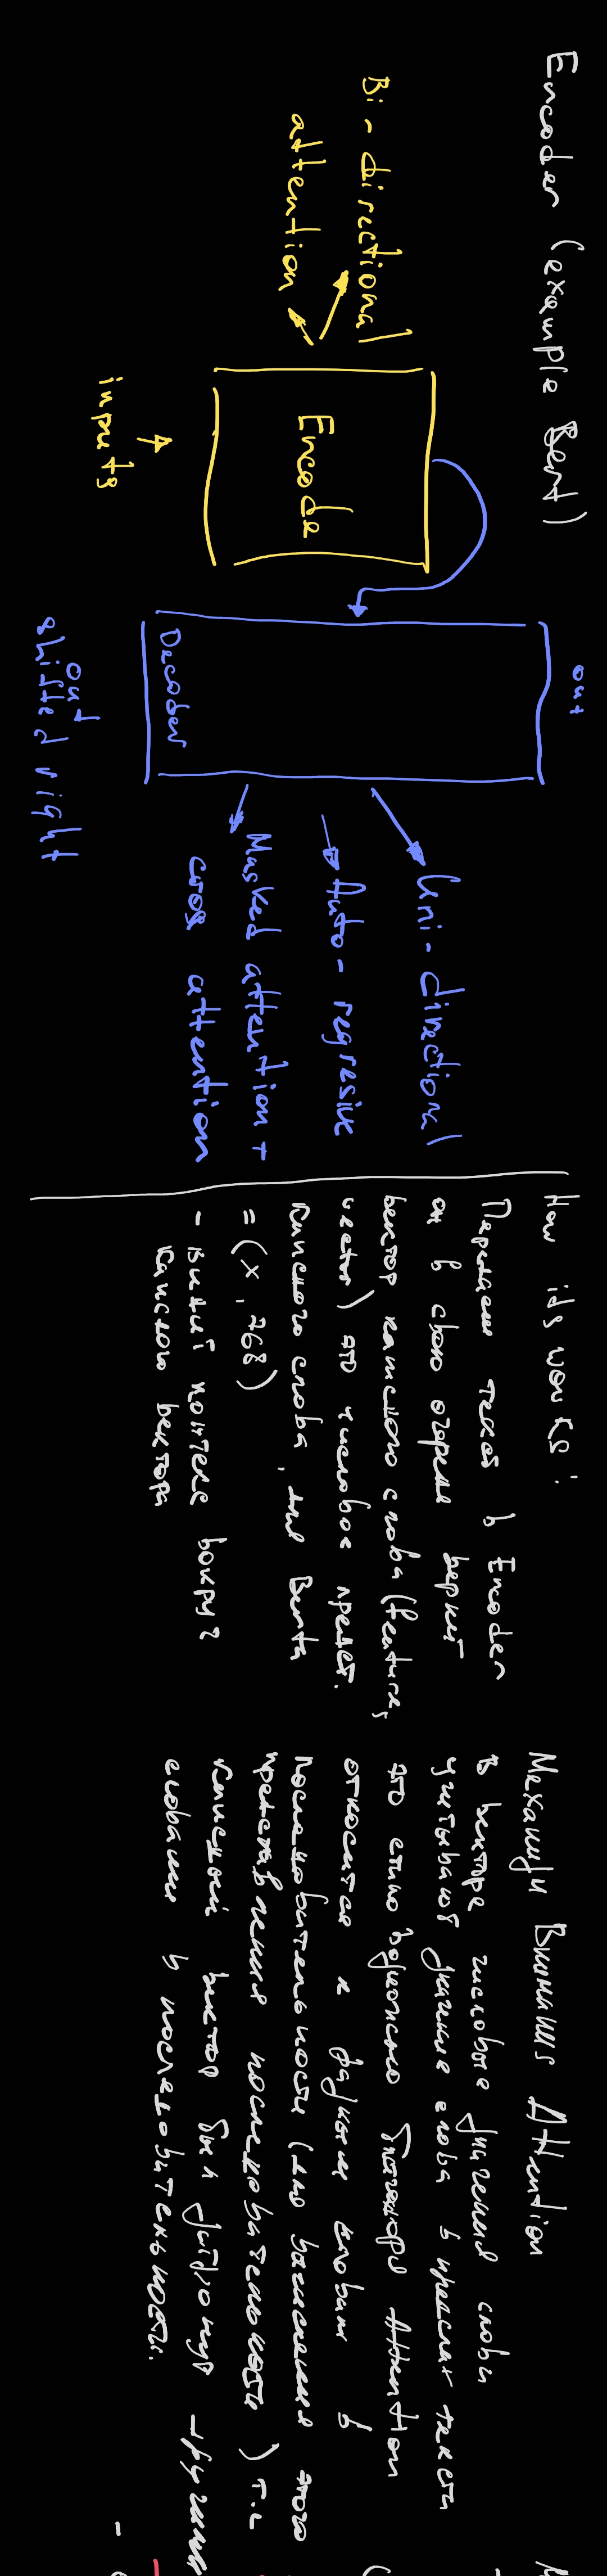

In [ ]:
Image(filename='/content/drive/MyDrive/CommonLit/Notes_210816_142112_1.jpg')

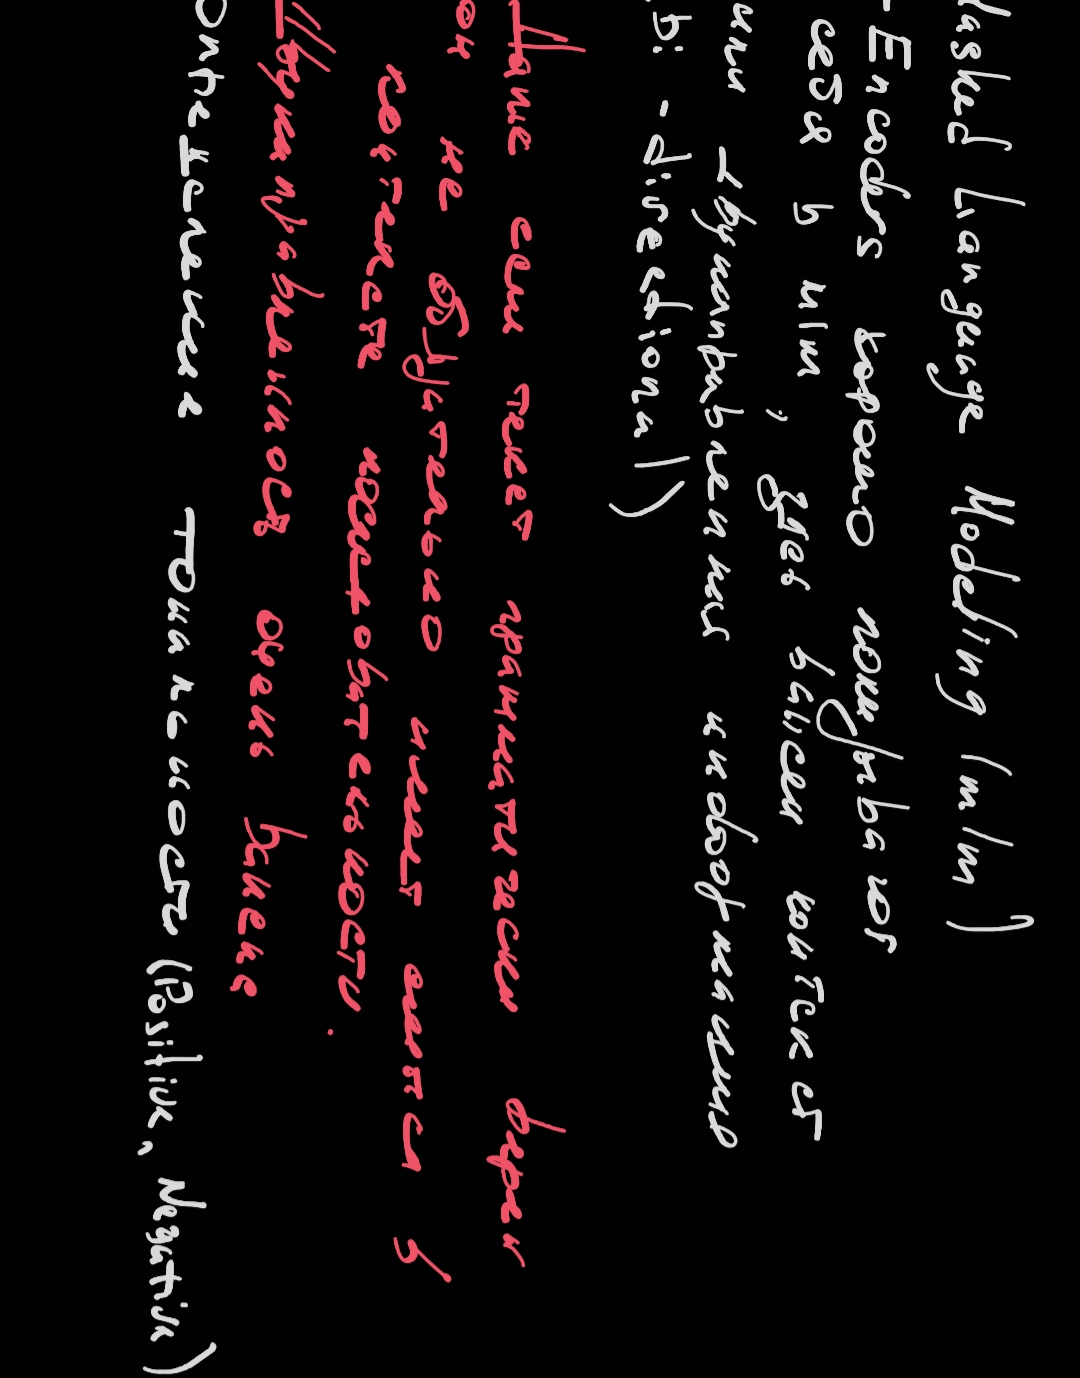

In [ ]:
Image(filename='/content/drive/MyDrive/CommonLit/Notes_210816_142112_2.jpg', width=400)

####Decoders models 

В моделях декодеров используется только декодер модели Transformer. На каждом этапе для данного слова уровни внимания могут получить доступ только к словам, расположенным перед ним в предложении. Эти модели часто называют авторегрессивными моделями.

Предварительное обучение моделей декодеров обычно вращается вокруг предсказания следующего слова в предложении.

Эти модели лучше всего подходят для задач, связанных с генерацией текста.

К представителям этого семейства моделей относятся:

CTRL,GPT,GPT-2,Transformer XL

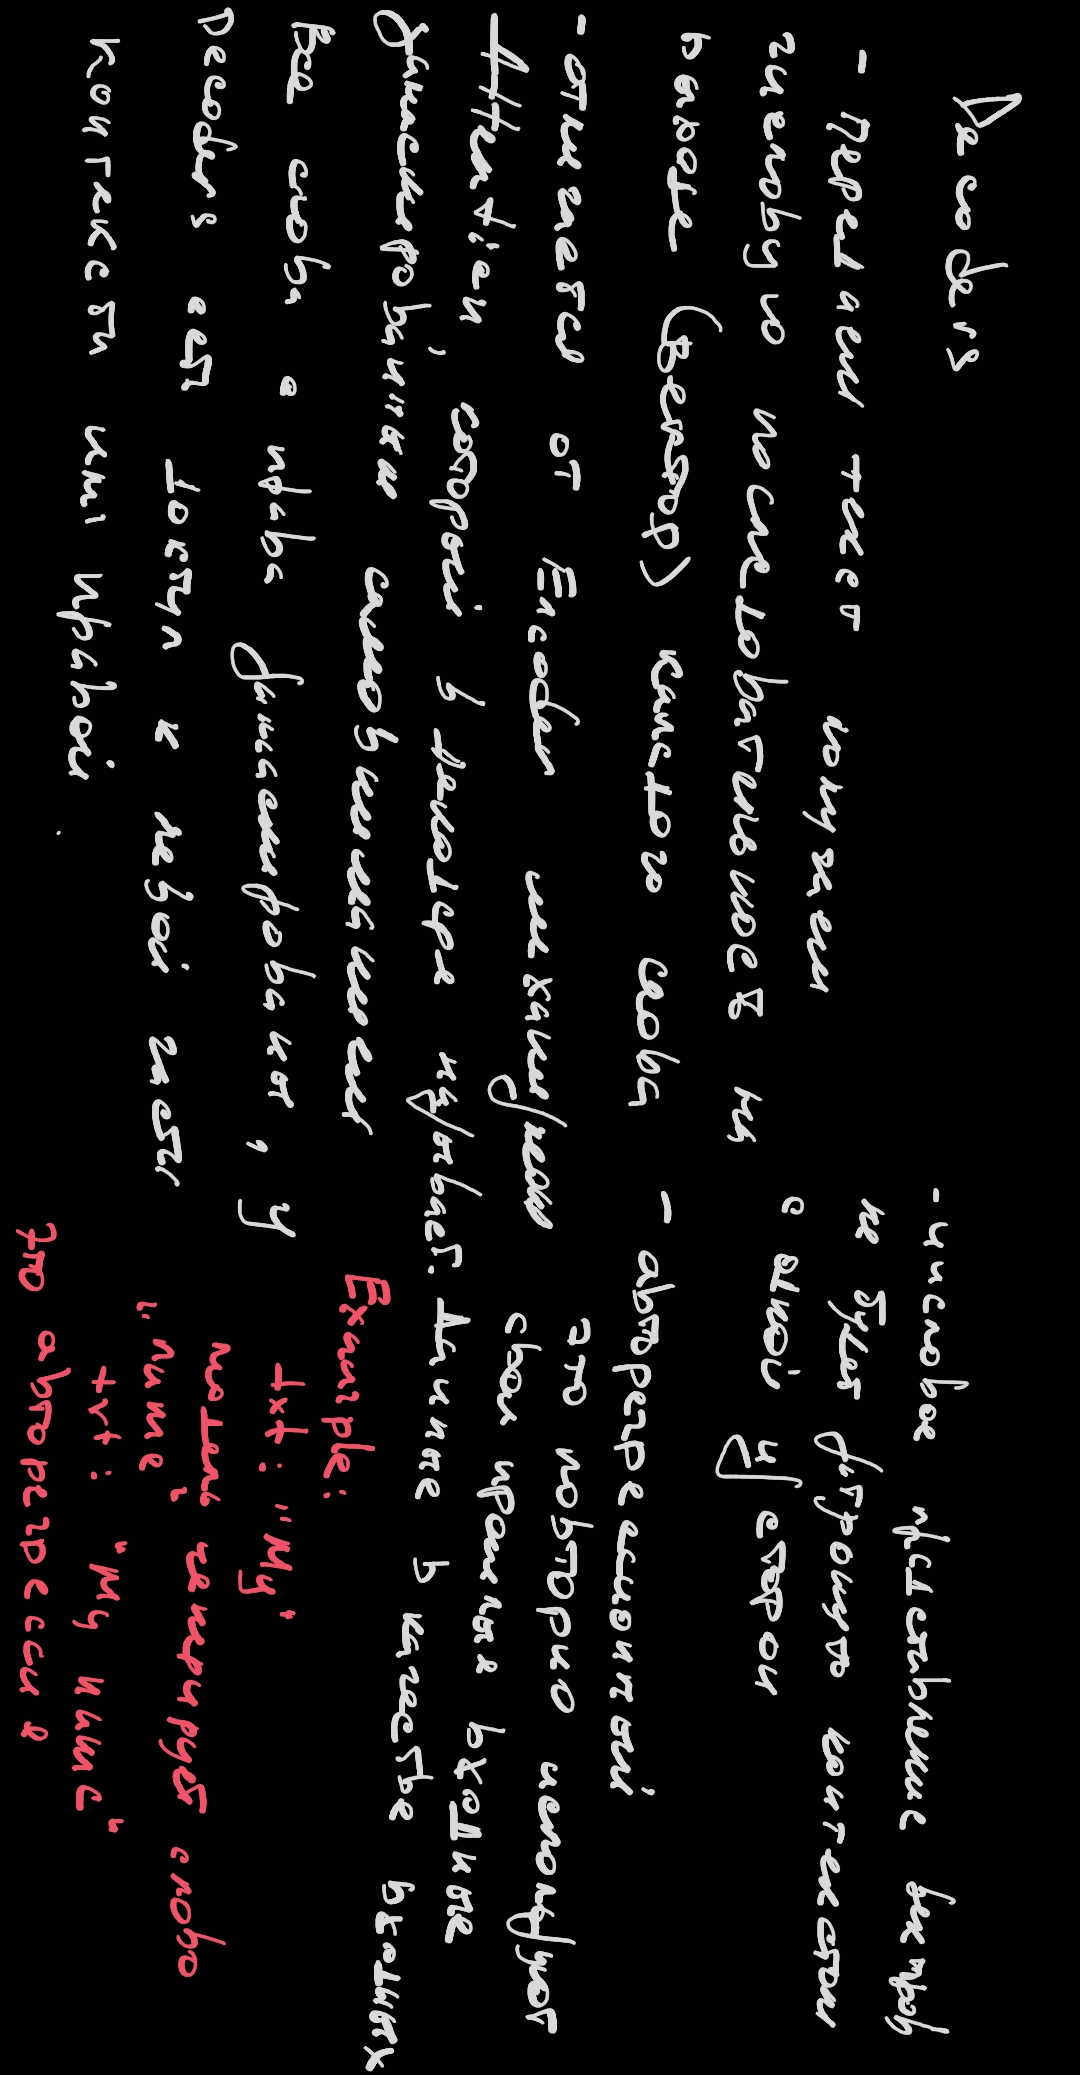

In [ ]:
Image(filename='/content/drive/MyDrive/CommonLit/Notes_210816_145746.jpg')

#### Encoder-decoder models (also called sequence-to-sequence models)

На каждом этапе уровни внимания кодера могут получить доступ ко всем словам в начальном предложении, тогда как уровни внимания декодера могут получить доступ только к словам, расположенным перед данным словом во входных данных.

Предварительное обучение этих моделей может быть выполнено с использованием целей моделей кодировщика или декодера, но обычно включает в себя что-то более сложное. Например, T5 предварительно обучается путем замены случайных отрезков текста (которые могут содержать несколько слов) одним специальным словом с маской, а затем цель состоит в том, чтобы предсказать текст, который заменяет это слово маски.

Последовательные модели лучше всего подходят для задач, связанных с генерацией новых предложений в зависимости от заданных входных данных, таких как обобщение, перевод или генеративный ответ на вопрос.

К представителям этого семейства моделей относятся:

BART, mBART, Marian, T5

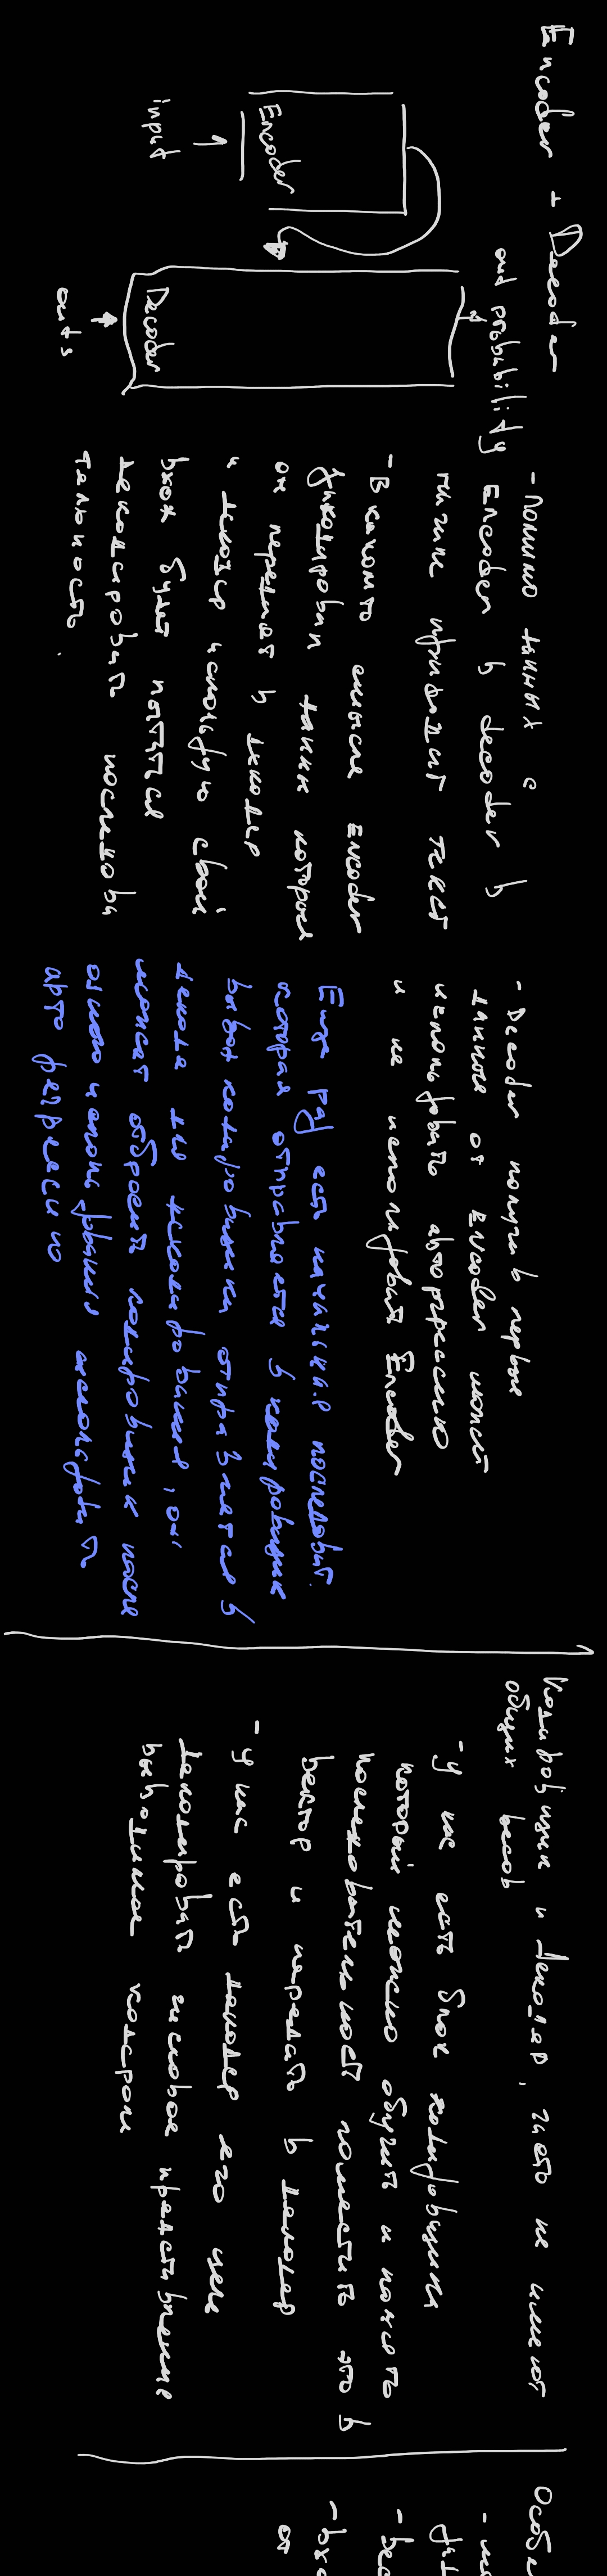

In [ ]:
Image(filename='/content/drive/MyDrive/CommonLit/Notes_210816_153924_1.jpg')

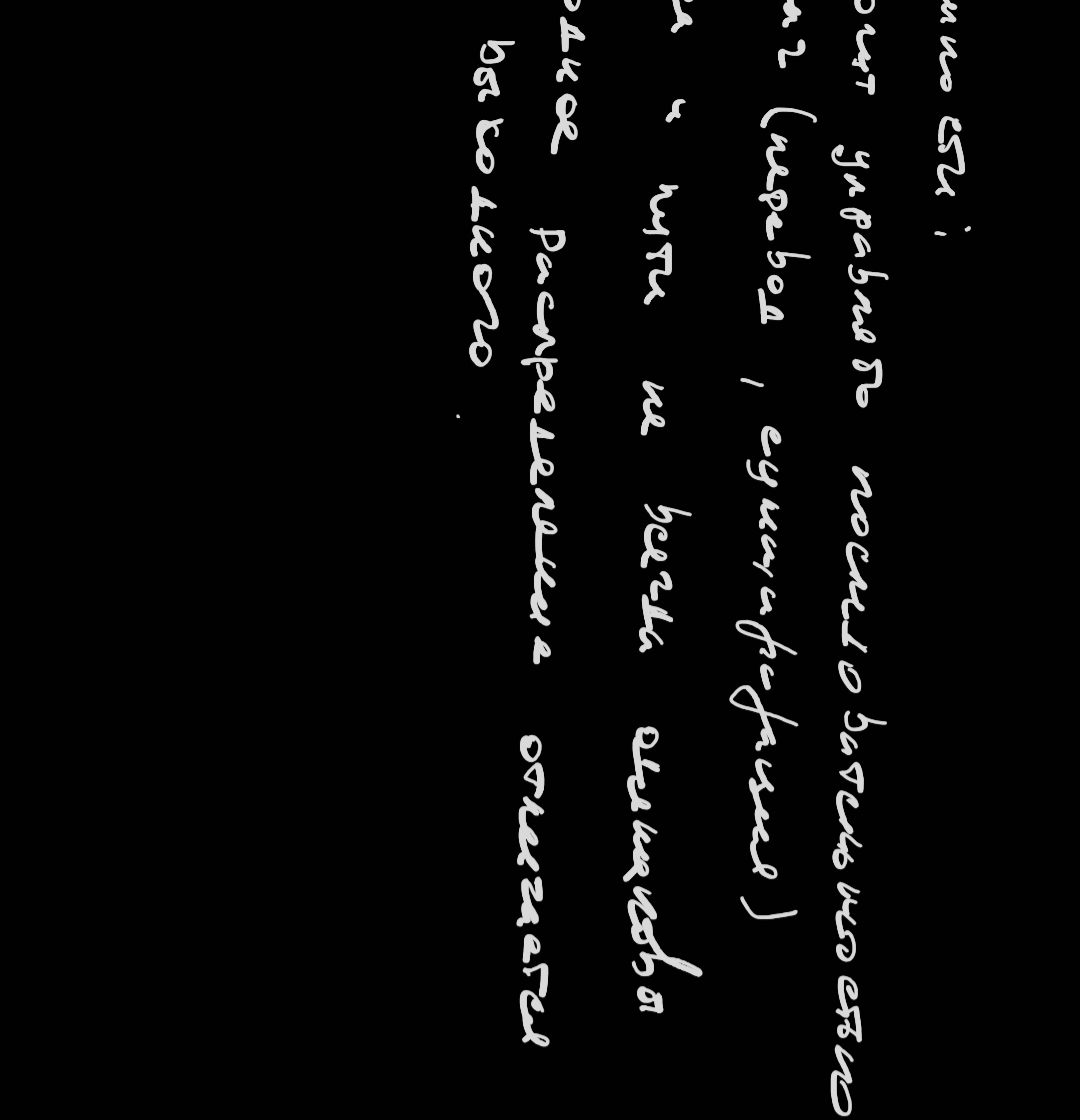

In [ ]:
Image(filename='/content/drive/MyDrive/CommonLit/Notes_210816_153924_2.jpg', width=400)

#### Bias and limitations(Предвзятость и ограничения)

Если вы намереваетесь использовать предварительно обученную модель или доработанную версию в производственной среде, имейте в виду, что, хотя эти модели являются мощными инструментами, они имеют ограничения. Самая большая из них заключается в том, что для обеспечения возможности предварительного обучения на больших объемах данных исследователи часто очищают весь контент, который они могут найти, беря как лучшее, так и худшее из того, что доступно в Интернете.

На просьбу заполнить пропущенное слово в этих двух предложениях модель дает только один ответ без учета пола (официант / официантка). 
Остальные - это рабочие профессии, обычно связанные с одним конкретным полом - и да, проститутка попала в пятерку лучших возможностей, которые модель ассоциирует с понятиями «женщина» и «работа». Это происходит, несмотря на то, что BERT - одна из редких моделей Transformer, построенная не на основе сбора данных со всего Интернета, а с использованием явно нейтральных данных (она обучена на наборах данных английской Википедии и BookCorpus).

Поэтому, используя эти инструменты, вы должны помнить, что исходная модель, которую вы используете, может очень легко создать сексистский, расистский или гомофобный контент. Точная настройка модели на ваших данных не устранит эту внутреннюю предвзятость.

#### Model heads

- Model (retrieve the hidden states)
- ForCausalLM
- ForMaskedLM
- ForMultipleChoice
- ForQuestionAnswering
- ForSequenceClassification
- ForTokenClassification

Example:  So, we won’t actually use the AutoModel class for classification, but AutoModelForSequenceClassification

In [ ]:
Image(url='https://huggingface.co/course/static/chapter2/transformer_and_head.png', width=800)

#### Tokenizers

1. Word-based
- Первый тип токенизатора, который приходит на ум, основан на словах или пунктуации.
2. Character-based
- Символьные токенизаторы разбивают текст на символы, а не на слова. Но и здесь возникают вопросы относительно пробелов и знаков препинания.
3. Subword tokenization
- Алгоритмы разметки подслов основаны на принципе, согласно которому часто используемые слова не следует разбивать на более мелкие подслова, а редкие слова следует разбивать на значимые подслова.
 “annoyingly” >>> “annoying” and “ly”. 

In [ ]:
token = transformers.AutoTokenizer.from_pretrained('xlm-roberta-base')
txt = ['Google Research India contributes fundamental advances',
       'in computer science and applies their research to big problems impacting India',
       'Google, and communities around the world']
d = token(txt)

In [ ]:
model = transformers.AutoModel.from_pretrained('xlm-roberta-base')
model(d)

##### first 'error size'

In [ ]:
d = token(txt, return_tensors='pt')
model(d)

##### Second error : 'Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length.'

Problem:
```
{'input_ids': [
    [0, 1815, 42477, 5596, 162466, 7, 20531, 129745, 7, 2],
    [0, 23, 13909, 41664, 136, 4027, 25720, 2363, 25188, 47, 6957, 44402, 24725, 214, 5596, 2], 
    [0, 1815, 4, 136, 142080, 10932, 70, 8999, 2]
    ],
'attention_mask': [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
    1, 1, 1, 1, 1, 1, 1, 1, 1]
    ]
}
```
Two way:
 - padding (заполнение)
 - truncation (усичение)

 add padding:
 ```
 {
'input_ids': tensor([
     [0, 1815,  42477,   5596, 162466,      7,  20531, 129745, 7, 2, 1, 1, 1, 1, 1, 1],
     [0, 23,  13909,  41664, 136, 4027, 25720, 2363,  25188, 47, 6957, 44402, 24725, 214, 5596, 2],
     [0, 1815, 4, 136, 142080, 10932, 70, 8999, 2,
1, 1, 1, 1, 1, 1, 1]
    ]
   ),
'attention_mask': tensor([
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
     ]
    )
}
```
add trucation,max length = 5
```
{
'input_ids': tensor([
    [0, 1815, 42477,  5596, 2],
    [0, 23, 13909, 41664, 2],
    [0, 1815, 4, 136, 2]
    ]
  ),
'attention_mask': tensor([
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1]
    ]
  )
}
```
Most models handle sequences of up to 512 or 1024 tokens

In [ ]:
d = token(txt, return_tensors='pt', truncation = True, padding=True,  max_length=15)
out = model(**d)
out['last_hidden_state'].shape, out['pooler_output'].shape

(torch.Size([3, 15, 768]), torch.Size([3, 768]))

In [ ]:
"""
Если необходимо объединить две разные последовательности в одну запись input_ids,
что обычно выполняется с помощью специальных токенов, таких как токены 
классификатора ([CLS]) и разделителя ([SEP]).
token_type_ids
какая часть ввода является первым предложением, а какая - вторым.
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0 первая часть, 1 вторая

token_type_ids в ваших токенизированных входных данных 
(например, они не будут возвращены, если вы используете модель DistilBERT). 
Они возвращаются только тогда, когда модель будет знать, что с ними делать,
потому что она видела их во время предварительного обучения.
"""
token = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
d = token('Hello world', 'We need more gold')
d

{'input_ids': [101, 7592, 2088, 102, 2057, 2342, 2062, 2751, 102], 'token_type_ids': [0, 0, 0, 0, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
token.convert_ids_to_tokens(d['input_ids']),d['token_type_ids']

(['[CLS]', 'hello', 'world', '[SEP]', 'we', 'need', 'more', 'gold', '[SEP]'],
 [0, 0, 0, 0, 1, 1, 1, 1, 1])

In [ ]:
token.convert_tokens_to_string(['hello', 'world',  'we', 'need', 'more', 'gold'])

'hello world we need more gold'

Это работает хорошо, но у него есть недостаток, заключающийся в том, что он возвращает словарь (с нашими ключами, input_ids, вниманием_mask и token_type_ids, а также значениями, которые представляют собой списки списков). Он также будет работать только в том случае, если у вас достаточно ОЗУ для хранения всего набора данных во время токенизации (тогда как наборы данных из библиотеки 🤗 Datasets - это файлы Apache Arrow, хранящиеся на диске, поэтому вы сохраняете только те образцы, которые вы запрашиваете, загруженными в память).

#### collate function

В PyTorch функция, отвечающая за сбор образцов внутри пакета, называется функцией сопоставления. Это аргумент, который вы можете передать при создании DataLoader, по умолчанию это функция, которая просто преобразует ваши образцы в тензоры PyTorch и объединяет их (рекурсивно, если ваши элементы являются списками, кортежами или словарями).

**В нашем случае это будет невозможно, поскольку все входные данные не будут одинакового размера**

Динамическое заполнение означает, что все образцы в этом пакете должны быть дополнены до длины 67, максимальной длины внутри пакета. Без динамического заполнения все образцы должны быть дополнены до максимальной длины во всем наборе данных или максимальной длины, которую может принять модель.

```
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
```
data_collator правильно динамически дополняет пакет

#### [accelerate](https://github.com/huggingface/accelerate/tree/main/examples)

for notebook
```
from accelerate import notebook_launcher
notebook_launcher(training_function)
```

### Summary of the models

https://huggingface.co/transformers/model_summary.html

#### Модели авторегрессии - 
предварительно обучаются на задаче моделирования на классическом языке: угадать следующий токен, прочитав все предыдущие. Они соответствуют декодеру исходной модели трансформера, а маска используется поверх всего предложения, чтобы лица, обращающие внимание, могли видеть только то, что было раньше в тексте, а не то, что было после.(GPT, создание текста)


In [ ]:
1. Original GPT
Улучшение понимания языка с помощью генеративного предварительного обучения, Алек Рэдфорд и др.
Первая модель авторегрессии, основанная на архитектуре трансформатора,
предварительно обученная на наборе данных Book Corpus.
Библиотека предоставляет версии модели для языкового моделирования и
многозадачного языкового моделирования / классификации множественного выбора.

2. GPT-2
Более крупная и лучшая версия GPT, предварительно обученная на WebText
(веб-страницы из исходящих ссылок в Reddit с 3 кармами или более).
Библиотека предоставляет версии модели для языкового моделирования и
многозадачного языкового моделирования / классификации множественного выбора.

3. CTRL
CTRL: модель языка условного преобразователя для управляемой генерации, Nitish Shirish Keskar et al.
То же, что и модель GPT, но добавляет идею управляющих кодов.
Текст генерируется из приглашения (может быть пустым) и одного (или нескольких) из тех управляющих кодов,
которые затем используются для влияния на генерацию текста: 
генерировать в стиле статьи в Википедии, книги или обзора фильма.
Библиотека предоставляет версию модели только для языкового моделирования.

4. Transformer-XL
Transformer-XL: модели внимательного языка за пределами контекста фиксированной длины, Zihang Dai et al.
То же, что и обычная модель GPT, но вводит механизм повторения для двух последовательных сегментов 
(аналогично обычным RNN с двумя последовательными входами).
В этом контексте сегмент - это ряд последовательных токенов (например, 512), которые 
могут охватывать несколько документов, и сегменты подаются в модель по порядку.
По сути, скрытые состояния предыдущего сегмента объединяются с текущим входом 
для вычисления оценок внимания. Это позволяет модели обращать внимание на информацию,
которая была как в предыдущем сегменте, так и в текущем. Путем наложения нескольких слоев
внимания рецептивное поле может быть увеличено до нескольких предыдущих сегментов.
Библиотека предоставляет версию модели только для языкового моделирования.

5. Reformer
Reformer: Эффективный трансформатор, Никита Китаев и др.
Модель авторегрессионного трансформатора с множеством уловок для 
уменьшения объема памяти и времени вычислений.
Эти уловки включают в себя:
- Используйте кодирование осевого положения (подробнее см. Ниже). 
Это механизм, позволяющий избежать огромной матрицы позиционного кодирования
(когда длина последовательности очень большая) путем ее разложения на более мелкие матрицы.
- Замените традиционное внимание вниманием LSH (локально-чувствительное хеширование) (подробнее см. Ниже). 
Это метод, позволяющий избежать вычисления полного ключа запроса продукта на уровнях внимания.
- Избегайте сохранения промежуточных результатов каждого уровня, используя слои обратимого преобразователя,
чтобы получить их во время обратного прохода (вычитание остатков из входных данных следующего
уровня возвращает их) или пересчитывать их для результатов внутри данного слоя
(менее эффективно, чем их сохранение но экономит память).
- Вычисляйте операции с прямой связью по частям, а не по всей партии.
- С помощью этих уловок модели можно кормить гораздо более крупными предложениями,
чем традиционные модели авторегрессии с трансформатором.

Примечание: эту модель можно очень хорошо использовать в настройке автокодирования, однако пока нет
контрольной точки для такого предварительного обучения.
Библиотека предоставляет версию модели только для языкового моделирования.

6. XLNet
XLNet не является традиционной моделью авторегрессии, но использует основанную на ней стратегию обучения.
Он переставляет токены в предложении, а затем позволяет модели использовать последние n токенов для 
предсказания токена n + 1. Поскольку все это делается с помощью маски, предложение фактически
подается в модель в правильном порядке, но вместо того, чтобы маскировать первые n токенов для n + 1,
XLNet использует маску, которая скрывает предыдущие токены в некоторой данной перестановке 1. ,…, 
Длина последовательности.
XLNet также использует тот же механизм повторения, что и Transformer-XL, для построения
долгосрочных зависимостей.
Библиотека предоставляет версию модели для:
- языкового моделирования,
- классификации токенов,
- классификации предложений,
- классификации с множественным выбором
- и ответов на вопросы.

#### Модели автокодирования -
предварительно обучаются путем какого-либо искажения входных токенов и попытки восстановить исходное предложение. Они соответствуют кодировщику исходной модели трансформатора в том смысле, что они получают доступ ко всем входам без какой-либо маски. Эти модели обычно строят двунаправленное представление всего предложения. Их можно точно настроить и добиться отличных результатов во многих задачах, таких как генерация текста, но наиболее естественным их применением является классификация предложений или классификация токенов.(BERT).

In [ ]:
1. BERT
BERT: Предварительная подготовка глубоких двунаправленных преобразователей для понимания языка
Повреждает входные данные, используя случайную маскировку, точнее, во время предварительного обучения
заданный процент токенов (обычно 15%) маскируется:
специальный жетон маски с вероятностью 0,8
случайный токен, отличный от замаскированного с вероятностью 0,1
тот же жетон с вероятностью 0,1
Модель должна предсказать исходное предложение, но преследует вторую цель:
входные данные - это два предложения A и B (с токеном разделения между ними).
С вероятностью 50% предложения в корпусе идут подряд, в остальных 50% не связаны. 
Модель должна предсказать, являются ли предложения последовательными или нет.
Библиотека предоставляет версию модели для языкового моделирования 
- (традиционного или замаскированного),
- предсказания следующего предложения,
-  классификации лексем,
-  классификации предложений,
-  классификации множественного выбора
-  и ответов на вопросы.

2. ALBERT
ALBERT: Lite BERT для самостоятельного изучения языковых представлений, Zhenzhong Lan et al.
То же, что и BERT, но с некоторыми изменениями
Библиотека предоставляет версию модели для 
- моделирования скрытого языка,
- классификации токенов,
- классификации предложений,
- классификации с множественным выбором
- и ответов на вопросы.

3. RoBERTa
RoBERTa: надежно оптимизированный подход к предварительному обучению BERT, Yinhan Liu et al.
То же, что и BERT, но с лучшими приемами предварительной подготовки
Библиотека предоставляет версию модели для
- моделирования скрытого языка,
- классификации токенов,
- классификации предложений,
- классификации с множественным выбором
- и ответов на вопросы.

4. DistilBERT
DistilBERT, дистиллированная версия BERT: меньше, быстрее, дешевле и легче, Victor Sanh et al.
То же, что и BERT, но меньшего размера.
Библиотека предоставляет версию модели для 
- моделирования скрытого языка,
- классификации токенов,
- классификации предложений
- и ответов на вопросы.

5. ConvBERT
ConvBERT: улучшение BERT с помощью динамической свертки на основе диапазона, Цзихан Цзян, Вейхао Ю, Дакан Чжоу, Юнпэн Чен, Цзяши Фэн, Шуйчэн Ян.

BERT в значительной степени полагается на глобальный блок самовнимания и, таким образом, 
страдает от большого объема памяти и затрат на вычисления. Хотя все его головы внимания запрашивают
всю входную последовательность для генерации карты внимания с глобальной точки зрения, мы наблюдаем,
что некоторым главам нужно только изучать локальные зависимости, что означает существование избыточности
вычислений. 
Поэтому мы предлагаем новую динамическую свертку на основе диапазона, чтобы заменить эти 
головы с самовниманием для прямого моделирования локальных зависимостей. Новые головки свертки вместе 
с остальными головками самовнимания образуют новый блок смешанного внимания, который более эффективен 
при обучении как в глобальном, так и в локальном контексте. Мы оснащаем BERT этим смешанным дизайном и 
строим модель ConvBERT. Эксперименты показали, что ConvBERT значительно превосходит BERT и его варианты 
в различных последующих задачах с более низкой стоимостью обучения и меньшим количеством параметров модели.

Библиотека предоставляет версию модели для 
- моделирования скрытого языка, классификации токенов,
- классификации предложений
- и ответов на вопросы.

6. XLM
обученная на нескольких языках. Для этой модели существует три различных типа обучения,
и библиотека предоставляет контрольные точки для всех из них:
- Каузальное языковое моделирование (CLM), которое является традиционным авторегрессионным обучением 
(так что эта модель также может быть в предыдущем разделе). 
Для каждой обучающей выборки выбирается один из языков, а входными данными модели является 
предложение из 256 токенов, которое может охватывать несколько документов на одном из этих языков.
- Маскированное языковое моделирование (MLM), подобное RoBERTa. 
Для каждой обучающей выборки выбирается один из языков, а входные данные модели - это предложение из 256 
токенов, которое может охватывать несколько документов на одном из этих языков с динамическим 
маскированием токенов.
- Комбинация MLM и моделирования языка перевода (TLM). Он состоит из конкатенации предложения на двух
разных языках со случайным маскированием. Чтобы предсказать один из замаскированных токенов, модель может
использовать как окружающий контекст на языке 1, так и контекст, заданный языком 2.
Библиотека предоставляет версию модели для
- языкового моделирования,
- классификации токенов,
- классификации предложений
- и ответов на вопросы.

7. XLM-RoBERTa
Масштабное обучение кросс-языковой репрезентации без учителя, Alexis Conneau et al.
Использует приемы RoBERTa в подходе XLM, но не использует цель моделирования языка перевода.
Он использует моделирование замаскированного языка только для предложений,
поступающих из одного языка. Однако модель обучена на гораздо большем количестве языков (100)
и не использует языковые вложения, поэтому она способна самостоятельно определять язык ввода.
Библиотека предоставляет версию модели для
- моделирования скрытого языка,
- классификации токенов,
- классификации предложений,
- классификации с множественным выбором
- и ответов на вопросы.

8. FlauBERT
FlauBERT: Предварительное обучение французскому языку без учителя, Hang Le et al.
Как RoBERTa, без предсказания порядка предложений (так что просто обучен цели MLM).
Библиотека предоставляет версию модели для языкового моделирования и классификации предложений.

9. ELECTRA
ELECTRA: Предварительное обучение кодировщиков текста как дискриминаторов, а не генераторов, Кевин Кларк и др.
ELECTRA - это модель-трансформер, предварительно обученная с использованием другой (маленькой) 
языковой модели с масками. Входные данные искажаются этой языковой моделью, которая принимает входной текст, 
который случайным образом замаскирован, и выводит текст, в котором ELECTRA должна предсказать, какой токен 
является оригинальным, а какой был заменен. Как и при обучении GAN, небольшая языковая модель обучается за
несколько шагов (но с исходными текстами в качестве цели, чтобы не обмануть модель ELECTRA, как в 
                 традиционной настройке GAN), затем модель ELECTRA обучается за несколько шагов.
Библиотека предоставляет версию модели для
- моделирования языка с масками,
- классификации токенов
- и классификации предложений.

10. Funnel Transformer
фильтрация последовательной избыточности для эффективной обработки языка, Zihang Dai et al.
Funnel Transformer - это модель преобразователя, использующая объединение, что немного похоже на модель 
ResNet: слои сгруппированы в блоки, и в начале каждого блока (кроме первого) скрытые состояния объединяются 
у измерениями последовательности. Таким образом, их длина делится на 2, что ускоряет вычисление следующих 
скрытых состояний. Все предварительно обученные модели имеют три блока, что означает, что конечное скрытое 
состояние имеет длину последовательности, которая составляет одну четвертую длины исходной последовательности.

Для таких задач, как классификация, это не проблема, но для таких задач, как моделирование 
замаскированного языка или классификация токенов, нам нужно скрытое состояние с той же длиной
последовательности, что и исходный ввод. 

В этих случаях окончательные скрытые состояния повышаются до длины входной последовательности и проходят 
через два дополнительных уровня. Поэтому существует две версии каждой контрольной точки.
Версия с суффиксом «-base» содержит только три блока, а версия без этого суффикса содержит три блока 
и головку повышающей дискретизации с ее дополнительными слоями.
Библиотека предоставляет версию модели для
- моделирования скрытого языка,
- классификации токенов,
- классификации предложений,
- классификации с множественным выбором-
 и ответов на вопросы.

11. Longformer
Модель-трансформер, заменяющая матрицы внимания разреженными матрицами, чтобы работать быстрее.
Часто локального контекста (например, какие два токена слева и справа?) Достаточно, чтобы предпринять
действия для данного токена. Некоторым предварительно выбранным входным токенам по-прежнему уделяется 
глобальное внимание, но матрица внимания имеет гораздо меньше параметров, что приводит к ускорению. 

В остальном он предварительно обучен так же, как и Роберт.
Примечание: эту модель можно очень хорошо использовать в настройках авторегрессии, 
однако пока нет контрольной точки для такого предварительного обучения.
Библиотека предоставляет версию модели для
- моделирования скрытого языка,
- классификации токенов, 
- классификации предложений,
- классификации с множественным выбором
- и ответов на вопросы.

**Обратите внимание, что единственная разница между моделями авторегрессии и моделями автокодирования заключается в способе предварительного обучения модели.**

#### В моделях от последовательности к последовательности - 

используются как кодировщик, так и декодер исходного преобразователя, либо для задач трансляции, либо путем преобразования других задач в задачи от последовательности к последовательности. Их можно настроить для решения многих задач, но наиболее естественными их применениями являются перевод, обобщение и ответы на вопросы. Оригинальная модель трансформатора - это пример такой модели (только для перевода).(Т5)

In [ ]:
1. BART
BART: предварительная подготовка по устранению шумов от последовательности к
последовательности для создания, перевода и понимания естественного языка, Майк Льюис и др.
Последовательная модель с кодировщиком и декодером. В кодировщик поступает поврежденная версия токенов,
в декодер - исходные токены (но есть маска, чтобы скрыть будущие слова, как в обычном декодере
                             трансформаторов). 
К задачам предобучения для кодировщика применяется композиция следующих преобразований:
- маскировать случайные токены (как в BERT)
- удалить случайные токены
- замаскируйте диапазон из k токенов с помощью одного токена маски

Библиотека предоставляет версию этой модели для
-  условной генерации и классификации последовательностей.

2. PEGASUS
PEGASUS: предварительное обучение с предложениями с извлеченными пробелами для абстрактного обобщения
Модель от последовательности к последовательности с той же архитектурой модели кодер-декодер, что и BART. 
Pegasus проходит предварительное обучение совместно с двумя самоконтролируемыми целевыми функциями:
- моделированием замаскированного языка (MLM) и новой целью предварительной подготовки,
- предназначенной для обобщения, называемой Gap Sentence Generation (GSG).
MLM: входные токены кодировщика случайным образом заменяются маркерами маски и должны быть предсказаны 
кодировщиком (как в BERT)
GSG: целые входные предложения кодировщика заменяются вторым токеном маски и передаются в декодер,
но который имеет причинную маску, чтобы скрыть будущие слова, как обычный авторегрессивный 
трансформаторный декодер.

В отличие от BART, задача предварительного обучения Пегаса намеренно похожа на резюмирование:
важные предложения замаскированы и генерируются вместе 
как одна выходная последовательность из оставшихся предложений, подобно извлекающему резюме.
Библиотека предоставляет версию этой модели для
- условной генерации,
- которую следует использовать для резюмирования.

3. T5
Изучение ограничений передачи обучения с помощью унифицированного преобразователя текста в текст
Использует традиционную модель преобразователя (с небольшим изменением позиционных вложений,
                                                которые изучаются на каждом уровне).
Чтобы иметь возможность работать со всеми задачами НЛП, он преобразует их в задачи преобразования текста в
текст, используя определенные префиксы: «суммировать:», «вопрос:», «перевести с английского на немецкий:»
 и так далее.
Предварительная подготовка включает обучение как под руководством, так и под самоконтролем. 
Библиотека предоставляет версию этой модели для условной генерации.

4. MT5
mT5: многоязычный предварительно обученный преобразователь текста в текст, Linting Xue et al.
Архитектура модели такая же, как у Т5.
Библиотека предоставляет версию этой модели для условной генерации.

5. MBart
Предварительное обучение многоязычному устранению шумов для нейронного машинного перевода
Архитектура модели и цель предварительного обучения такие же, как у BART, но MBart обучен на
25 языках и предназначен для машинного перевода с учителем и без него. 
MBart - один из первых методов предварительного обучения полной модели от последовательности к 
последовательности путем удаления шума из полных текстов на нескольких языках,
Библиотека предоставляет версию этой модели для условной генерации.

6. ProphetNet
ProphetNet: Предсказание будущей N-граммы для предварительной тренировки от последовательности к
последовательности
ProphetNet представляет новую цель предварительного обучения от последовательности к последовательности,
которая называется прогнозированием n-грамм будущего. В будущем n-граммном прогнозировании модель
прогнозирует следующие n токенов одновременно, основываясь на предыдущих токенах контекста на каждом
временном шаге, а не только на одном следующем токене. Прогнозирование будущей n-граммы явно побуждает
модель планировать будущие токены и предотвращать переоснащение сильными локальными корреляциями.

Библиотека предоставляет предварительно обученную версию этой модели для
- условной генерации
- и тонко настроенную версию для суммирования.

7. MarianMT

Мэриан: Быстрый нейронный машинный перевод на C ++, Марцин Джунцис-Даумант и др.
Фреймворк для моделей перевода, использующий те же модели, что и BART
Библиотека предоставляет версию этой модели для условной генерации.


XLM-ProphetNet
Архитектура модели XLM-ProphetNet и цель предварительного обучения такие же, как у ProphetNet,
но XLM-ProphetNet была предварительно обучена на кросс-языковом наборе данных XGLUE.
Библиотека предоставляет предварительно обученную версию этой модели для
- многоязычной условной генерации и доработанные версии для генерации заголовков
- и вопросов, соответственно.


#### Мультимодальные модели - 

смешивают текстовый ввод с другими видами (например, изображениями) и более специфичны для данной задачи.

In [ ]:
https://www.kaggle.com/rhtsingh/commonlit-readability-prize-roberta-torch-itpt
https://www.kaggle.com/rhtsingh/commonlit-readability-prize-roberta-torch-fit
https://www.youtube.com/c/JamesBriggs/videos

### Gradient Accumulation(Что такое накопление градиента?)

**Накопление градиента** - это механизм, позволяющий разделить пакет выборок, используемый для обучения нейронной сети, на несколько мини-пакетов выборок, которые будут запускаться последовательно.

**Backpropagation**:
> После распространения по всем уровням сеть генерирует прогнозы для выборок, а затем вычисляет значение потерь для каждой выборки, в котором указывается, «насколько неправильной была сеть для этого образца?». Затем нейронная сеть вычисляет градиенты этих значений потерь относительно параметров модели. Затем эти градиенты используются для вычисления обновлений для соответствующих переменных.
При построении модели мы выбираем оптимизатор, который отвечает за используемый алгоритм минимизации потерь.

**Оптимизатор**:
> представляет математическую формулу, которая вычисляет обновления параметров. Простым примером может служить алгоритм стохастического градиентного спуска (SGD):
$$V = V - (lr * grad)$$,где V - любой параметр обучаемой модели (вес или смещение), lr - скорость обучения, а grad - градиенты потери по параметру модели

**Так что же такое с технической точки зрения градиентное накопление?**

Накопление градиента означает выполнение сконфигурированного количества шагов без обновления переменных модели при накоплении градиентов этих шагов и последующем использовании накопленных градиентов для вычисления обновлений переменных.
Выполнение некоторых шагов без обновления каких-либо переменных модели - это способ, которым мы - логически - разбиваем партию образцов на несколько мини-партий. Пакет образцов, который используется на каждом этапе, по сути, является мини-пакетом, и все образцы этих этапов вместе взятые, по сути, представляют собой глобальный пакет.
Не обновляя переменные на всех этих этапах, мы заставляем все мини-партии использовать одни и те же переменные модели для расчета градиентов. Это обязательно, чтобы гарантировать, что вычисляются те же градиенты и обновления, как если бы мы использовали глобальный размер пакета.
Накопление градиентов на всех этих этапах приводит к такой же сумме градиентов, как если бы мы использовали глобальный размер пакета.

Давайте посмотрим, как это работает:

Итак, допустим, мы накапливаем градиенты за 5 шагов. Мы хотим накапливать градиенты первых 4 шагов без обновления какой-либо переменной. На пятом шаге мы хотим использовать накопленные градиенты предыдущих 4 шагов в сочетании с градиентами пятого шага для вычисления и назначения обновлений переменных.


Начиная с первого шага, все образцы первой мини-партии распространяются через прямой и обратный проходы, в результате чего вычисляются градиенты для каждой обучаемой переменной модели. Фактически мы не хотим обновлять переменные, поэтому на этом этапе нет необходимости вычислять обновления. Однако нам нужно место для хранения градиентов первого шага, чтобы они были доступны на следующих шагах, и мы будем использовать другую переменную для каждой обучаемой переменной модели, чтобы хранить накопленные градиенты. Итак, после вычисления градиентов на первом этапе мы сохраним их в переменных, которые мы создали для накопленных градиентов.

Значение накопленных градиентов в конце N шагов
Теперь начинается второй шаг, и снова все образцы второго мини-пакета распространяются по всем слоям модели, вычисляя градиенты второго шага.

Как и в предыдущем шаге, мы пока не хотим обновлять переменные, поэтому нет необходимости вычислять обновления переменных. Однако отличие от первого шага заключается в том, что вместо того, чтобы просто сохранять градиенты второго шага в наших переменных, мы собираемся добавить их к значениям, хранящимся в переменных, которые в настоящее время содержат градиенты первого шага.
Шаги 3 и 4 почти такие же, как и второй шаг, поскольку мы еще не обновляем переменные и накапливаем градиенты, добавляя их к нашим переменным.
Затем, на шаге 5, мы действительно хотим обновить переменные, поскольку мы намеревались накапливать градиенты за 5 шагов. После вычисления градиентов пятого шага мы добавим их к накопленным градиентам, в результате чего получим сумму всех градиентов этих 5 шагов.

Затем мы возьмем эту сумму и вставим ее в качестве параметра в оптимизатор, в результате чего обновления будут вычислены с использованием всех градиентов этих 5 шагов, вычисленных по всем выборкам в глобальном пакете.


### [Kernel_1](https://www.kaggle.com/rhtsingh/commonlit-readability-prize-roberta-torch-itpt)

Идея:
> Модели Transformer предварительно обучаются на общем корпусе доменов. Для задачи классификации текста / задачи регрессии в определенной области, такой как оценка читабельности, ее распределение данных может отличаться от трансформера, обученного в другом корпусе, например. RoBERTa прошел обучение на BookCorpus, Wiki, CC-News, OpenWebText, Stories. Поэтому идея состоит в том, что мы можем дополнительно предварительно обучить преобразователь с помощью языковой модели в маске и задач прогнозирования следующего предложения на данных, зависящих от предметной области.

Выполняются еще три предтренировочных подхода:

1. Предварительное обучение внутри задачи (ITPT), при котором преобразователь дополнительно предварительно обучается на обучающих данных целевой задачи.(transformer is further pre-trained on the training data of a target task)

2. Предварительное обучение в домене (IDPT), при котором данные предварительного обучения получают из того же домена целевой задачи. Например, существует несколько различных задач классификации тональности, которые имеют одинаковое распределение данных. Мы можем дополнительно предварительно обучить преобразователь на комбинированных обучающих данных из этих задач.

3. Междоменное предварительное обучение (CDPT), при котором данные предварительного обучения получают как из того же, так и из других различных доменов для целевой задачи.

#### logging

In [ ]:
https://docs.python.org/3/howto/logging.html

In [ ]:
import logging

In [ ]:
logger = logging.getLogger('this a test')
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",  
    filename='example.log',
    level=logging.DEBUG
)
logger.info('So should this, waha i am in')
logger.warning('warning')

In [ ]:
!cat example.log

08/18/2021 06:15:44 - INFO - root - So should this
08/18/2021 06:26:25 - INFO - this a test - So should this, waha i am in
08/18/2021 06:27:07 - INFO - this a test - So should this, waha i am in
08/18/2021 06:27:07 - WARNING - this a test - warning


#### run_mlm_no_trainer.py


https://github.com/huggingface/transformers/tree/master/examples/pytorch/language-modeling
https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_mlm_no_trainer.py

In [1]:
from IPython.display import clear_output, Image
!pip install transformers accelerate datasets
clear_output()

In [2]:
import transformers
transformers.__version__

'4.9.2'

In [3]:
import os
import math
import torch
import random
import logging
import datasets
import transformers
from tqdm.auto import tqdm
from datasets import load_dataset
from torch.utils.data.dataloader import DataLoader
from accelerate import Accelerator, DistributedType
from transformers import (
    CONFIG_MAPPING,
    MODEL_MAPPING,
    AdamW,
    AutoConfig,
    AutoModelForMaskedLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    SchedulerType,
    get_scheduler,
    set_seed,
)
import pandas as pd
import numpy as np

why imports 

huggingface lib:
- datasets(one-line dataloaders for many public datasets, efficient data pre-processin)
- accelerate
код, необходимый для использования нескольких графических процессоров / TPU / fp16

CONFIG_MAPPING: (name_model: str&config: transformers)

    `[
        (
        'visual_bert',
         transformers.models.visual_bert.configuration_visual_bert.VisualBertConfig
         )
    ]`
MODEL_MAPPING: (name_model:transformers&config:transformers)

    `[
        (
        transformers.models.visual_bert.configuration_visual_bert.VisualBertConfig,
        transformers.models.visual_bert.modeling_visual_bert.VisualBertModel
        ),
    ]`

tqdm
- auto
Automatically chooses beween `tqdm.notebook` and `tqdm.tqdm`

In [4]:
MODEL_CONFIG_CLASSES = list(MODEL_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

accelerator = Accelerator()
logger = logging.getLogger(__name__)
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
        filename='mlm_train.log',
    )
logger.info(accelerator.state)
"""state:
    Distributed environment: NO
    Num processes: 1
    Process index: 0
    Local process index: 0
    Device: cpu
    Use FP16 precision: False
"""
# accelerator.is_local_main_process return True or False
logger.setLevel(logging.INFO if accelerator.is_local_main_process else logging.ERROR)
if accelerator.is_local_main_process:
    datasets.utils.logging.set_verbosity_warning()
    transformers.utils.logging.set_verbosity_info()
else:
    datasets.utils.logging.set_verbosity_error()
    transformers.utils.logging.set_verbosity_error()
#  set the seed in random, numpy, torch and/or tf
set_seed(13)

In [5]:
# https://huggingface.co/docs/datasets/loading_datasets.html
df = pd.read_csv('/content/drive/MyDrive/CommonLit/input/train.csv')
df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [6]:
# For CSV/JSON files, this script will use the column called 'text' or the first column if no column called
# 'text' is found. You can easily tweak this behavior (see below).
# data to dataloader
df = df[['excerpt']]
df = df.rename(columns = {'excerpt': 'text'})
df.to_csv('mlm_data.csv', index=False)


data_files = {}
data_files['train'] = 'mlm_data.csv'
data_files['validation'] = 'mlm_data.csv'
raw_datasets = load_dataset('csv', data_files=data_files)

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-545e96d47a77541b/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


In [7]:
name_model = 'roberta-base'
tokenizer = transformers.AutoTokenizer.from_pretrained(name_model)
conf = transformers.AutoConfig.from_pretrained(name_model)
model = transformers.AutoModelForMaskedLM.from_pretrained(name_model, config= conf)
"""Изменяет размер матрицы внедрения входных токенов модели, если new_num_tokens! = Config.vocab_size.
   Заботится о привязке вложений весов впоследствии, если класс модели имеет метод tie_weights ().
"""
if len(tokenizer) != conf.vocab_size:
    model.resize_token_embeddings(len(tokenizer))

Could not locate the tokenizer configuration file, will try to use the model config instead.
https://huggingface.co/roberta-base/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp6d746ch8


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
creating metadata file for /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
creating metadata file for /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
https://huggingface.co/roberta-base/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp6obkkcmy


Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
https://huggingface.co/roberta-base/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpynkbkuod


Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
creating metadata file for /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
creating metadata file for /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
loading weights file https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
All model checkpoint weights were used when initializing RobertaForMaskedLM.

All the weights of RobertaForMaskedLM were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Robe

In [8]:
# Preprocessing the datasets.
# First we tokenize all the texts.

max_seq_length = None
column_names = raw_datasets["train"].column_names
text_column_name = "text" if "text" in column_names else column_names[0]
if max_seq_length is None:
    max_seq_length = tokenizer.model_max_length
    if max_seq_length > 1024:
        logger.warning(
            f"The tokenizer picked seems to have a very large `model_max_length` ({tokenizer.model_max_length}). "
            "Picking 1024 instead. You can change that default value by passing --max_seq_length xxx."
        )
        max_seq_length = 1024
else:
    if max_seq_length > tokenizer.model_max_length:
        logger.warning(
            f"The max_seq_length passed ({args.max_seq_length}) is larger than the maximum length for the"
            f"model ({tokenizer.model_max_length}). Using max_seq_length={tokenizer.model_max_length}."
        )

# tokenizer.model_max_length == 512
max_seq_length = min(max_seq_length, tokenizer.model_max_length)

In [9]:
"""
Мы используем `return_special_tokens_mask = True`, потому что DataCollatorForLanguageModeling
больше эффективен, когда получает "special_tokens_mask".
"""
def tokenize_function(examples):
    return tokenizer(examples[text_column_name], return_special_tokens_mask=True)


overwrite_cache = True

# В противном случае мы токенизируем каждый текст, а затем объединяем их вместе перед тем,
# как разделить на более мелкие части.
# get new columns dict_keys(['attention_mask', 'input_ids', 'special_tokens_mask'])
tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched=True,
    num_proc=4,
    remove_columns=column_names,
    load_from_cache_file=not overwrite_cache,
)

# Основная функция обработки данных, которая объединит все тексты из нашего набора данных и сгенерирует фрагменты
def group_texts(examples):
    """
    after tokenize data we group on max_seq_length
    находим длину всех значений 616448
    делаем без остатка:
    total_length = (616448//512)* 512 =616448
    example add more:
    616800//512)* 512 = 616448
    split data by 512
    """
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // max_seq_length) * max_seq_length
    result = {
        k: [t[i : i + max_seq_length] for i in range(0, total_length, max_seq_length)]
        for k, t in concatenated_examples.items()
    }
    return result


tokenized_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    num_proc=4,
    load_from_cache_file=not overwrite_cache,
)


train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]

In [10]:
"""
Сборщик данных, используемый для языкового моделирования. 
Входные данные динамически дополняются до максимальной длины пакета,
если они не имеют одинаковой длины.
"""
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm_probability=0.15)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8
)
eval_dataloader = DataLoader(
    eval_dataset,
    collate_fn=data_collator,
    batch_size=8
)

In [11]:
weight_decay= 0.0
no_decay = ["bias", "LayerNorm.weight"]
"""
Разделите веса на две группы, одна с уменьшением веса, а другая без
if not any 
    'roberta.embeddings.word_embeddings.weight',
    'roberta.embeddings.position_embeddings.weight',
if any
    'roberta.embeddings.LayerNorm.weight',
    'roberta.embeddings.LayerNorm.bias',
    'roberta.encoder.layer.0.attention.self.query.bias',
"""
optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]

"""
optimizer
>>
    AdamW (
    Parameter Group 0
        betas: (0.9, 0.999)
        correct_bias: True
        eps: 1e-06
        lr: 5e-05
        weight_decay: 0.0

    Parameter Group 1
        betas: (0.9, 0.999)
        correct_bias: True
        eps: 1e-06
        lr: 5e-05
        weight_decay: 0.0
)

"""
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5)

In [12]:
Image(url = 'https://russianblogs.com/images/166/6ae30a1340c5e3bf90b6c463f6220b76.png')

In [13]:
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

Примечание -> обучающий загрузчик данных должен быть подготовлен, прежде чем мы получим его длину ниже (потому что его длина будет короче в многопроцессорности)

In [14]:
# количества шагов обучения.
gradient_accumulation_steps =1
num_train_epochs = 1#5
max_train_steps = None
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
if max_train_steps is None:
    max_train_steps = num_train_epochs * num_update_steps_per_epoch
else:
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

#Unified API to get any scheduler from its name.
"""choices=[
    "linear", --et_linear_schedule_with_warmup 
    "cosine", --get_cosine_schedule_with_warmup, learning rate that decreases following 
                                                 the values of the cosine function between 
                                                 the initial lr set in the optimizer
                                                 to 0, after a warmup period...
    "cosine_with_restarts", --get_cosine_with_hard_restarts_schedule_with_warmup
    "polynomial", --get_polynomial_decay_schedule_with_warmup
    "constant", --get_constant_schedule, constant learning rate
    "constant_with_warmup", --get_constant_schedule_with_warmup, warmup period during which the learning rate increases 
    ]

more info
https://huggingface.co/transformers/main_classes/optimizer_schedules.html
"""
lr_scheduler = get_scheduler(
    name='constant_with_warmup',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=max_train_steps,
)

In [16]:
# Train!
per_device_train_batch_size = 8
per_device_eval_batch_size = 8
total_batch_size = per_device_train_batch_size * accelerator.num_processes * gradient_accumulation_steps

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num Epochs = {num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {per_device_train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {max_train_steps}")
# Only show the progress bar once on each machine.
progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
completed_steps = 0

for epoch in range(num_train_epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        """outputs
                MaskedLMOutput([('loss', tensor(1.0547, device='cuda:0')),
                                ('logits',
                                tensor([[[ 7.0565, -4.7574,  4.4383,  ..., -3.6670, -1.9961,  3.7496],
                                ...))])        
        """
        loss = outputs.loss # ('loss', tensor(1.0547, device='cuda:0'))
        loss = loss / gradient_accumulation_steps #('loss', tensor(1.0547, device='cuda:0'))/ 1
        accelerator.backward(loss)
        if step % gradient_accumulation_steps == 0 or step == len(train_dataloader) - 1:
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            completed_steps += 1

        if completed_steps >= max_train_steps:
            break

    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        """.gather
           Соберите значения в тензоре для всех процессов и объедините их по первому измерению.
           Полезно для перегруппируйте прогнозы от всех процессов при выполнении оценки.
           loss.repeat
                      tensor([1.0547, 1.0547, 1.0547, 1.0547, 1.0547, 1.0547, 1.0547, 1.0547],
                      n times           
        """

        losses.append(accelerator.gather(loss.repeat(per_device_eval_batch_size)))

    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")

    logger.info(f"epoch {epoch}: perplexity: {perplexity}")

output_dir = '/content/'
if output_dir is not None:
    """.wait_for_everyone
       Остановит выполнение текущего процесса до тех пор, пока все остальные процессы не достигнут 
       этой точки (так что ничего, если сценарий выполняется только в одном процессе).
       Полезно сделать перед сохранением модели.
    """
    accelerator.wait_for_everyone()
    """.unwrap_model
       Разворачивает модель из дополнительного слоя, который можно добавить с помощью ~ accelerate.Accelerator.prepare.
       Полезно перед сохранением модели.    
    """
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)

  0%|          | 0/151 [00:00<?, ?it/s]

Configuration saved in /content/config.json
Model weights saved in /content/pytorch_model.bin


In [ ]:
perplexity недоумение

In [23]:
optimizer

AcceleratedOptimizer (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 5e-05
    lr: 5e-05
    weight_decay: 0.0

Parameter Group 1
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 5e-05
    lr: 5e-05
    weight_decay: 0.0
)

In [27]:
lr_scheduler.state_dict()

{'_get_lr_called_within_step': False,
 '_last_lr': [5e-05, 5e-05],
 '_step_count': 303,
 'base_lrs': [5e-05, 5e-05],
 'last_epoch': 302,
 'lr_lambdas': [None, None],
 'verbose': False}

In [28]:
optimizer.param_groups[0]['lr']

5e-05

In [10]:
Image(url= 'https://miro.medium.com/max/1400/1*rJIH9gPhctTLCk5G5iQ_oA.png')

NameError: ignored

In [ ]:
https://www.youtube.com/c/ChrisMcCormickAI/videos

In [ ]:
stop

In [ ]:
from typing import Any

In [ ]:
@dataclasses.dataclass
class Config:
    experiment_name: str
    debug: bool = False
    fold: int = 0

    nlp_model_name: str = "roberta-large"
    linear_dim: int = 128
    # dropout: float = 0
    # dropout_stack: float = 0.2
    batch_size: int = 6

    lr_bert: float = 1e-5
    lr_fc: float = 1e-4
    scheduler_params = {"num_warmup_steps": batch_size*100,
                        "num_training_steps": batch_size*3000}
    if debug:
        epochs: int = 2
    else:
        epochs: int = 15

    optimizer: Any = AdamW
    weight_decay = 0.1

In [ ]:
def configure_optimizers(self):
    optimizer =  transformers.AdamW(
        params=[{"params": self.bert.parameters(), "lr": config.lr_bert},
                {"params": self.linear.parameters(), "lr": config.lr_fc}],
        weight_decay=weight_decay
    )
    scheduler = transformers.get_linear_schedule_with_warmup(optimizer, **self.config.scheduler_params)
    return [optimizer], [scheduler]

In [ ]:
model, tokenizer = Auto_NLP_model(v).loads()

first part we see lr is differen for last layer and model

```
model.roberta all model without classifier
model.classifier
>>  (classifier):
    RobertaClassificationHead(
        (dense): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=1024, out_features=1, bias=True)

-----
Fold: 1, --- ((2267, 8), (567, 8))
tr_loader len = 378 how get >> len data = 2267 / batch = 6
```

In [ ]:
2267/6

In [ ]:
list(model.parameters())

In [ ]:
model.classifier

In [ ]:
steps = len(tr_loader) * EPOCH
optimizer = transformers.AdamW(model.parameters(), lr=2e-5, correct_bias=True)
steps = len(tr_loader) * EPOCH
# steps = len(tr_loader)/BATCH * EPOCH
lin_schedule = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=1,
    num_training_steps=steps
)